# Using MySQL Connector: Classic Cars Database

In this notebook I'll be working with MySQL.Connector in order to run SQL queries in Python and create some visualizations. Although this task could very easily be done in Tableau or Power BI, Python and all of the availible libraries offer **a lot** more flexibility so should we want to do a deeper analysis, it's good to know how to use these tools.

<br>
The classic cars database contains data on a fictional company that sells model cars. The database is comprised of 8 tables with various data on employees, customers, products and orders.

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Each time we run the MySQL connector, it needs your credentials to access the database, so I've saved the following as 'config' to make things easier. If you were using this, you'd have to switch the ### out with your information and have granted the correct permissions as well.

config = {'user': ###, 'password': ###, 'auth_plugin' : 'mysql_native_password', 
          'host': 'localhost', 'database': 'classicmodels'}

In [2]:
config = {'user': 'William', 'password': 'SQLpassword', 'auth_plugin' : 'mysql_native_password', 
          'host': 'localhost', 'database': 'classicmodels'}

In [3]:
# Each time we connect to the database we need to use the mysql.connector:

cnx = mysql.connector.connect(**config) # connect with config-user details
cursor = cnx.cursor()                   # cursor object 


# SQL code goes in between the three quotes and is run using cursor.execute
cursor.execute("""SHOW tables""")

# use cursor fetchall to retrieve the SQL output and save it to a variable we can work with
output = cursor.fetchall()

    
cursor.close()                          # close the cursor
cnx.close()                             # close the connection


# return the output as a pandas dataframe
pd.DataFrame(output, columns = ['Tables'])

,Tables
0,customers
1,employees
2,offices
3,order_numbers
4,orderdetails
5,orders
6,payments
7,productlines
8,products


So here are the names of the 8 tables that are shown in the [Classic Cars Schema](https://github.com/etauzer/MySQL_connector/blob/main/MySQL-Sample-Database-Schema.png). Some things that we might like to learn about the company are:

- How many offices/employees do they have and where are they located?
- What are the product lines and how are they broken down? How much do they markup their products? 
- What are some of the most profitable/popular products that they sell?
- Which employees bring in the most sales/orders/customers?
- Who are the top customers 
- How long does it take for ship date from order date sorted by different cities

# Employees

For the employees, we'd like to know how many employees there are, where they work, and what their positions are. We can extract data on them and their positions, locations, and we can create a map to get an idea of what sort of coverage they have and where their customers are.

In [4]:
cnx = mysql.connector.connect(**config)                # connect 
cursor = cnx.cursor()                   

# We can run several queries at once. the first, for counting the number of employees, the second for some employee
# data and the third is for information on where customers are located.

cursor.execute("""SELECT COUNT(*) FROM employees; """) 
num_emp = cursor.fetchall()


print('There are a total of {} employees'.format(num_emp[0][0]))

cursor.execute("""SELECT firstName,
       lastName,
       jobTitle,
       city, 
       state,
       country
       FROM employees AS e
       LEFT JOIN offices AS o
       ON e.officeCode = o.officeCode
       ORDER BY state, city
       ;""")
employees = cursor.fetchall()



cursor.execute("""SELECT country,
       city,
       COUNT(*) AS num_customers
       FROM customers
       GROUP BY country, city
       ORDER BY num_customers DESC
       ;""")
customers = cursor.fetchall()


cursor.close()                           
cnx.close()

employees_loc = pd.DataFrame(employees, columns = ['First Name', 'Last Name', 'Position', 'City', 'State', 'Country'])
customers_loc = pd.DataFrame(customers, columns = ['Country', 'City', 'Num_Customers'])

There are a total of 23 employees


In [5]:
employees_loc.groupby(['Country', 'City', 'Position'])['City'].count()

Country    City           Position            
Australia  Sydney         Sales Manager (APAC)    1
                          Sales Rep               3
France     Paris          Sale Manager (EMEA)     1
                          Sales Rep               4
Japan      Tokyo          Sales Rep               2
UK         London         Sales Rep               2
USA        Boston         Sales Rep               2
           NYC            Sales Rep               2
           San Francisco  President               1
                          Sales Manager (NA)      1
                          Sales Rep               2
                          VP Marketing            1
                          VP Sales                1
Name: City, dtype: int64

Summarizing the table above (which we could also do in SQL, but it looks nicer in Pandas) gives a better idea of the company structure. It appears that San Francisco is the overall headquarters and in charge of North America, with Paris the regional headquarters for EMEA (Europe, Middle East, Africa) and Sydney being that of APAC(Asian Pacific).

### Total Revenue by City

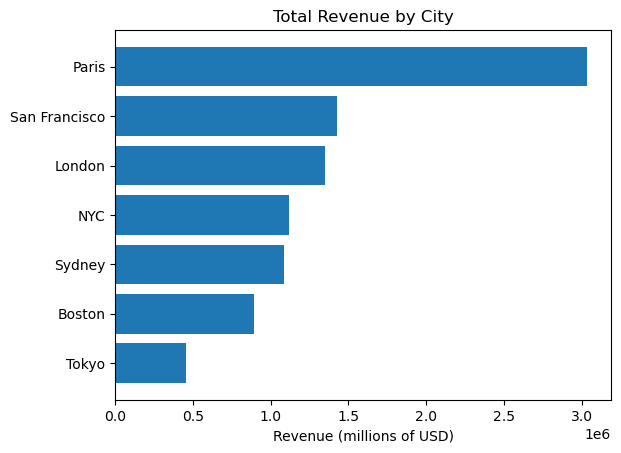

In [6]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()

cursor.execute("""WITH city_rev AS (
       SELECT offices.city,
       orderdetails.quantityOrdered * orderdetails.priceEach AS rev
       FROM offices
       LEFT JOIN employees AS e
       ON offices.officeCode = e.officeCode
       LEFT JOIN customers AS c
       ON e.employeeNumber = c.salesRepEmployeeNumber
       LEFT JOIN orders
       ON c.customerNumber = orders.customerNumber
       LEFT JOIN orderdetails
       ON orders.orderNumber = orderdetails.orderNumber
       WHERE status != 'Cancelled')
       
       SELECT city, SUM(rev) FROM city_rev
       GROUP BY city
       ORDER BY SUM(rev);
       """)
output = cursor.fetchall()

cursor.close()                           
cnx.close()

rev_by_city = pd.DataFrame(output, columns = ['City', 'Total_Revenue']).set_index('City')


x_pos = np.arange(len(rev_by_city['Total_Revenue']))   # x-coordinates of bars for each city
plt.barh(x_pos, rev_by_city['Total_Revenue'], color = 'tab:blue')


plt.xlabel('Revenue (millions of USD)'); 
plt.title('Total Revenue by City') # label the title and y-axis
plt.yticks(x_pos, rev_by_city.index, ha='right');

In [7]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()

cursor.execute("""SELECT RANK() OVER(ORDER BY Count(employeeNumber) DESC) AS ranking,
       firstName,
       lastName,
       offices.city,
       Count(employeeNumber) AS numberOfCustomers
       FROM employees AS e
       LEFT JOIN customers AS c
       ON e.employeeNumber = c.salesRepEmployeeNumber
       INNER JOIN offices
       ON e.officeCode = offices.officeCode
       GROUP BY employeeNumber
       LIMIT 5;
       """)
top_cust = cursor.fetchall()


cursor.execute("""SELECT RANK() OVER(ORDER BY Count(employeeNumber) DESC) AS Ranking,
       firstName,
       lastName,
       offices.city,
       SUM(od.quantityOrdered * od.priceEach) AS Revenue
       FROM employees AS e
       LEFT JOIN customers AS c
       ON e.employeeNumber = c.salesRepEmployeeNumber
       INNER JOIN orders as o
       ON o.customerNumber = c.customerNumber
       INNER JOIN orderdetails as od
       ON o.orderNumber = od.orderNumber
       INNER JOIN offices
       ON e.officeCode = offices.officeCode
       GROUP BY employeeNumber
       LIMIT 5;
       """)
top_sales = cursor.fetchall()

cursor.close()                           
cnx.close()

display(pd.DataFrame(top_cust, columns = ['Rank','First Name', 'Last Name', 'Branch', 'Number of Customers']).set_index('Rank'))
display(pd.DataFrame(top_sales, columns = ['Rank','First Name', 'Last Name', 'Branch', 'Revenue']).set_index('Rank'))

,First Name,Last Name,Branch,Number of Customers
Rank,,,,
1,Pamela,Castillo,Paris,10
2,Barry,Jones,London,9
3,George,Vanauf,NYC,8
3,Larry,Bott,London,8
5,Foon Yue,Tseng,NYC,7


,First Name,Last Name,Branch,Revenue
Rank,,,,
1,Gerard,Hernandez,Paris,1258577.81
2,Leslie,Jennings,San Francisco,1081530.54
3,Pamela,Castillo,Paris,868220.55
4,Larry,Bott,London,732096.79
5,Barry,Jones,London,704853.91


It looks like Paris has both the employee with the most customers (Pamela Castillo) and the the employee with the most sales (Gerard Hernandez). We have data on the location of customers and the offices so we could plot them all on a map to get a better idea of the company and its reach.

In [8]:
# We can use the geopandas library for creating the map
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

In [9]:
# The geopandas library has some citis included in it. Our database has abbreviated New York City as NYC so we need to
# change that
employees_loc = employees_loc.replace('NYC', 'New York')

offices = cities[cities.name.isin(employees_loc.City)]
offices

,name,geometry
175,San Francisco,POINT (-122.39960 37.78426)
218,New York,POINT (-73.99572 40.72156)
219,London,POINT (-0.11867 51.50194)
233,Tokyo,POINT (139.74946 35.68696)
235,Paris,POINT (2.35299 48.85809)
240,Sydney,POINT (151.21255 -33.87137)


There doesn't appear to be any information on Boston, which means that geopandas library doesn't have it. So we can create a geopandas dataframe with the relevant latitude and longitude for Boston and add it to the list.

In [10]:
from shapely.geometry import Point

# create a geodataframe with the correct coordinates
boston_latlong = {'name': ['Boston'], 'geometry': [Point(-71.0589, 42.3601)]}
boston = geopandas.GeoDataFrame(boston_latlong, crs="EPSG:4326")

# concatenate it with the other dataframce
offices = pd.concat([offices, boston]).reset_index(drop=True)
offices

,name,geometry
0,San Francisco,POINT (-122.39960 37.78426)
1,New York,POINT (-73.99572 40.72156)
2,London,POINT (-0.11867 51.50194)
3,Tokyo,POINT (139.74946 35.68696)
4,Paris,POINT (2.35299 48.85809)
5,Sydney,POINT (151.21255 -33.87137)
6,Boston,POINT (-71.05890 42.36010)


In [11]:
# We can use the number of employees in each branch to affect how large the marker is on the map

office_counts = pd.DataFrame(employees_loc.groupby('City').count()['Position'])
office_counts = office_counts.rename(columns={'Position':'emp_count'})
offices = offices.set_index('name').join(office_counts)

To Do: Add customers to map

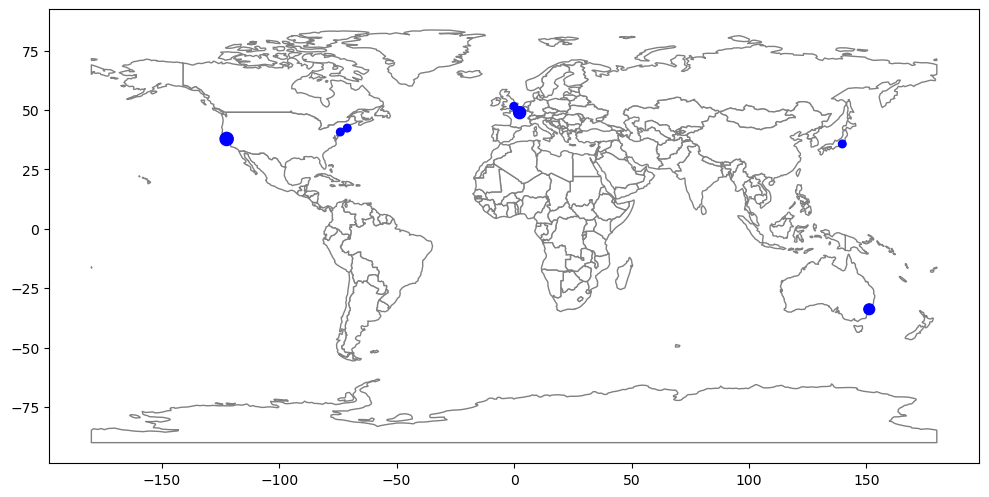

In [12]:
plt.rcParams['figure.figsize'] = [12, 7] # make the plot a bit bigger
base = world.plot(color='white', edgecolor='grey')

offices.plot(ax=base, marker='o', color='blue', markersize=15*offices.emp_count);

# Products

Next we can look into the types of products sold and the product lines that the company has along with information on how much they sell their products for and what the markup is

In [13]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()                   

cursor.execute("""SELECT pl.productLine,
       productName,
       buyPrice,
       MSRP
       FROM productLines AS pl
       LEFT JOIN products AS p
       ON pl.productLine = p.productLine
       ;""")
output = cursor.fetchall()

cursor.close()                           
cnx.close()

products = pd.DataFrame(output, columns = ['product_line', 'product_name', 'buy_price', 'msrp'])

In [14]:
product_line_summary = products.groupby(['product_line'])['product_name'].count().sort_values(ascending = False)
product_line_summary

product_line
Classic Cars        38
Vintage Cars        24
Motorcycles         13
Planes              12
Trucks and Buses    11
Ships                9
Trains               3
Name: product_name, dtype: int64

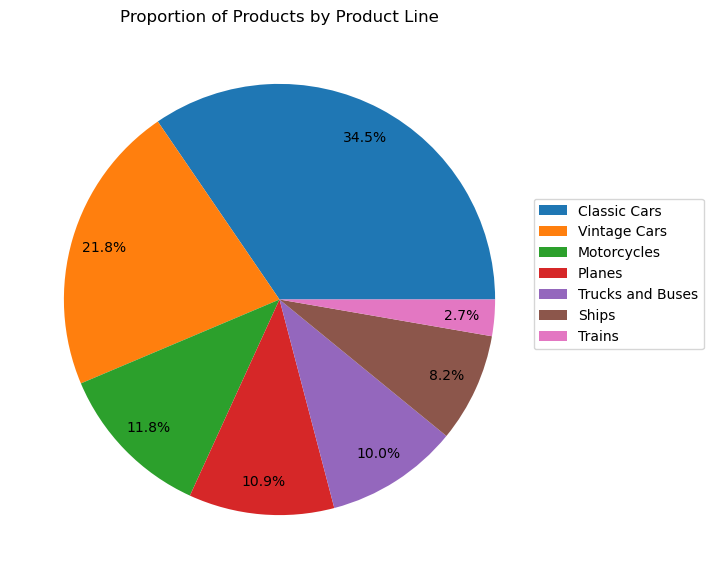

In [15]:
# Pie Chart
plt.pie(product_line_summary.values, 
        autopct='%1.1f%%', pctdistance=0.85)
plt.title("Proportion of Products by Product Line")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, .7), labels=product_line_summary.index,);
 

We can also use the information in the table above to figure our a bit more about the prices associated which each product line. To do so in Python, we'd create a dictionary associating each price with each product line. With that dictionary, we can associate each price with a product line and make a boxplot to get a better idea of average pricing by product line.

In [16]:
# Set the product lines to be the keys in the dictionary
product_lines = product_line_summary.index

# Using dictionary comprehension create a dictionary that associates each price with a product line
line_dict = {line:list(products.loc[products.product_line == line].msrp.astype('float')) for line in product_lines}

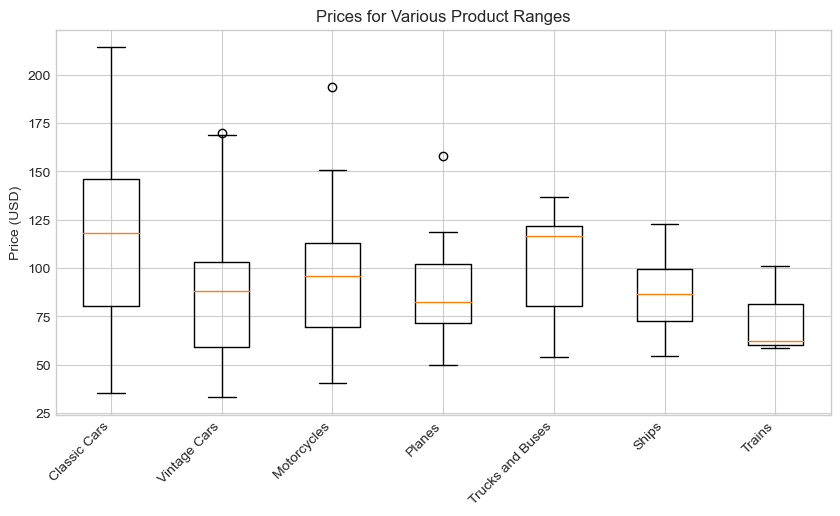

In [17]:
plt.rcParams['figure.figsize'] = [10, 5] # make the plot a bit bigger

# We can plot a boxplot using the dictionary keys as the x labels, 
# which will let us get an idea of the prices associated with each product line
plt.style.use('seaborn-v0_8-whitegrid')

ax = plt.axes() 
ax.boxplot(line_dict.values())
ax.set_xticklabels(line_dict.keys());

# Create appropiate labels and fix the angle and position of labels
plt.ylabel('Price (USD)'); 
plt.title('Prices for Various Product Ranges')
plt.xticks(ha = 'right', rotation = 45);

Looks like the Classic Cars not only have the most products in that line but also tend to be a bit pricier on average than the other product lines, with only Trucks and Buses having a comparable mean (but much lower upper quartile and maximum). Overall, the majority of the models have MSRP between 50-150 USD. We could make a similar plot to determine how much they markup their products as well.

In [18]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()                   

cursor.execute("""WITH products AS(
                       SELECT  productLine,
                       buyPrice AS buy_price,
                       priceEach AS price_sold
                       FROM products
                       INNER JOIN orderdetails
                       ON orderdetails.productCode = products.productCode
                       )
                       SELECT *, ROUND(100*(price_sold - buy_price)/buy_price,2) 
                       FROM products
                       
                       ;""")
results = cursor.fetchall()

cursor.close()                           
cnx.close()

products = pd.DataFrame(results, columns = ['product_line', 'buy_price', 'price_sold', 'markup'])

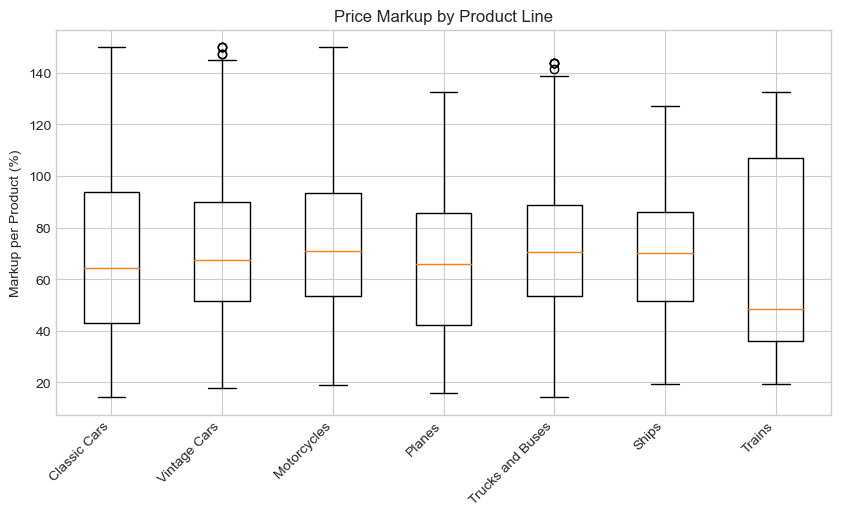

In [19]:
plt.rcParams['figure.figsize'] = [10, 5]
# Using dictionary comprehension create a dictionary that associates each price with a product line
prof_dict = {line:list(products.loc[products.product_line == line].markup.astype('float')) for line in product_lines}

# We can plot a boxplot using the dictionary keys as the x labels, 
# which will let us get an idea of the prices associated with each product line

ax = plt.axes() 
ax.boxplot(prof_dict.values())
ax.set_xticklabels(prof_dict.keys());

# Create appropiate labels and fix the angle and position of labels
plt.ylabel('Markup per Product (%)'); 
plt.title('Price Markup by Product Line')
plt.xticks(ha = 'right', rotation = 45);

The markups are fairly consistent across product lines with trains having the most variability in how much they are marked up. Overall, their average markup is lower than averages for every other product line as it's the only one with an average markup under 40%. There are only 3 train lines as well, so it could be that it is not as popular and is sometimes sold as a discount.


## Sales Growth by Product Line
Next, we can look deeper into what products are more profitable and how sale have been over the past few years. First lets look how sales growth has been in each of the product lines from 2003 to 2004 

In [20]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()                   

# We can use a subquerry in order to round off the sales growth percentage
cursor.execute("""SELECT *, ROUND((sales_2004-sales_2003)*100/sales_2003, 1) AS sales_growth 
                    FROM
                    (SELECT
                    productLine,
                    SUM(IF(YEAR(orderDate) = 2003, priceEach*quantityOrdered, 0)) AS sales_2003,
                    SUM(IF(YEAR(orderDate) = 2004, priceEach*quantityOrdered, 0)) AS sales_2004
                    FROM products 
                    LEFT JOIN orderdetails 
                    ON products.productCode = orderdetails.productCode
                    LEFT JOIN orders 
                    ON orderdetails.orderNumber = orders.orderNumber
                    WHERE status != 'Cancelled'
                    GROUP BY productLine
                    ) sub
                    ORDER BY sales_growth DESC
                    ;""")
output = cursor.fetchall()

cursor.close()                           
cnx.close()

sales_growth = pd.DataFrame(output, columns = ['Product_Line', 'Sales_2003', 'Sales_2004', 'Sales_Growth'])
sales_growth = sales_growth.set_index('Product_Line')

# Just to make the table looks bit nicer
sales_growth.Sales_Growth = sales_growth.Sales_Growth.astype(str) + '%'
sales_growth.style.format({"Sales 2003": "{:,.0f}", "Sales 2004": "{:,.0f}"})

,Sales_2003,Sales_2004,Sales_Growth
Product_Line,,,
Planes,284773.21,445464.30,56.4%
Motorcycles,344998.74,527243.84,52.8%
Ships,201044.48,305951.40,52.2%
Vintage Cars,607535.32,823927.95,35.6%
Trains,65822.05,86897.46,32.0%
Trucks and Buses,376657.12,465390.00,23.6%
Classic Cars,1369386.78,1689307.07,23.4%


Sales Growth has been in the positive direction for all product lines with Planes, Motorcycles and Ships all increasing by more than %50 in sales. Classic Cars and Trucks & Buses had the slowest growth but Classic Cars is one of the biggest lines so that's to be expected. We can go ahead and plot the performance of each line below for a better idea of how they performed over the two year.

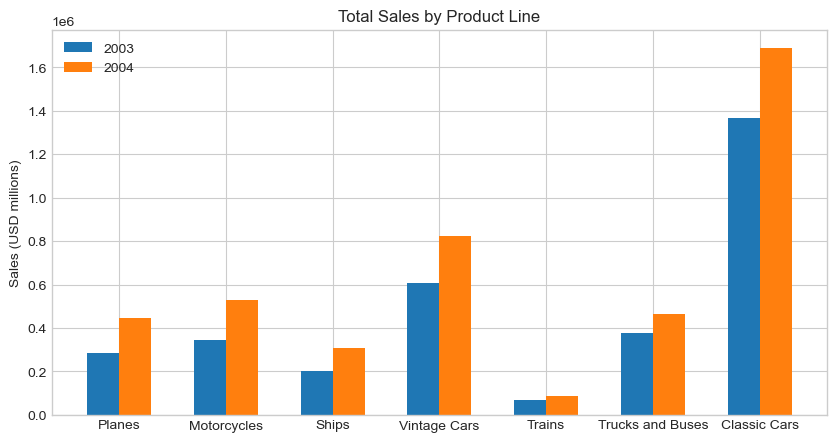

In [21]:
plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()  
ax = plt.axes() 

x_pos = sales_growth.index.values

ax.bar(x_pos, sales_growth['Sales_2003'], align = 'edge', width = -.3, label = '2003')
ax.bar(x_pos, sales_growth['Sales_2004'], align = 'edge', width = .3, label = '2004')
ax.set(ylabel="Sales (USD millions)", title = 'Total Sales by Product Line')


plt.xticks(rotation = 0)
ax.legend();


## Top 5 products in terms of qty and Bottom 5.

In [22]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()                   

cursor.execute("""SELECT productName, 
                    quantityInStock,
                    SUM(quantityOrdered)
                    FROM products 
                    LEFT JOIN orderdetails 
                    ON products.productCode = orderdetails.productCode
                    LEFT JOIN orders 
                    ON orderdetails.orderNumber = orders.orderNumber
                    WHERE status != 'Cancelled'
                    GROUP BY productName, quantityInStock
                    ORDER BY SUM(quantityOrdered) DESC
                    ;""")
output = cursor.fetchall()

cursor.close()                           
cnx.close()

pd.DataFrame(output)


,0,1,2
0,1992 Ferrari 360 Spider red,8347,1768
1,1937 Lincoln Berline,8693,1111
2,1940s Ford truck,3128,1061
3,1969 Harley Davidson Ultimate Chopper,7933,1057
4,1957 Chevy Pickup,6125,1056
...,...,...,...
104,1903 Ford Model A,3913,819
105,1999 Indy 500 Monte Carlo SS,8164,818
106,1937 Horch 930V Limousine,2902,806
107,1970 Chevy Chevelle SS 454,1005,803


## Products that have declined in popularity

In [23]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()                   

cursor.execute("""WITH qty_sold AS (SELECT productName,
                    SUM(IF(YEAR(orderDate) = 2003, quantityOrdered, 0)) AS qty_sold_2003,
                    SUM(IF(YEAR(orderDate) = 2004, quantityOrdered, 0)) AS qty_sold_2004
                    FROM products 
                    LEFT JOIN orderdetails 
                    ON products.productCode = orderdetails.productCode
                    LEFT JOIN orders 
                    ON orderdetails.orderNumber = orders.orderNumber
                    WHERE status != 'Cancelled'
                    GROUP BY productName, quantityInStock
                    ORDER BY SUM(quantityOrdered) DESC)
                    
                    SELECT productName, qty_sold_2003, qty_sold_2004,
                    ROUND(100*(qty_sold_2004-qty_sold_2003)/qty_sold_2003, 2) AS qty_sold
                    FROM qty_sold
                    ORDER BY qty_sold DESC
                    ;""")
output = cursor.fetchall()

cursor.close()                           
cnx.close()

qty_sold = pd.DataFrame(output, columns = ['product', 'qty_sold_2003', 'qty_sold_2004', 'qty_sold_growth'])
qty_sold = qty_sold.set_index('product')
top_5 = qty_sold.head()
bot_5 = qty_sold.tail()

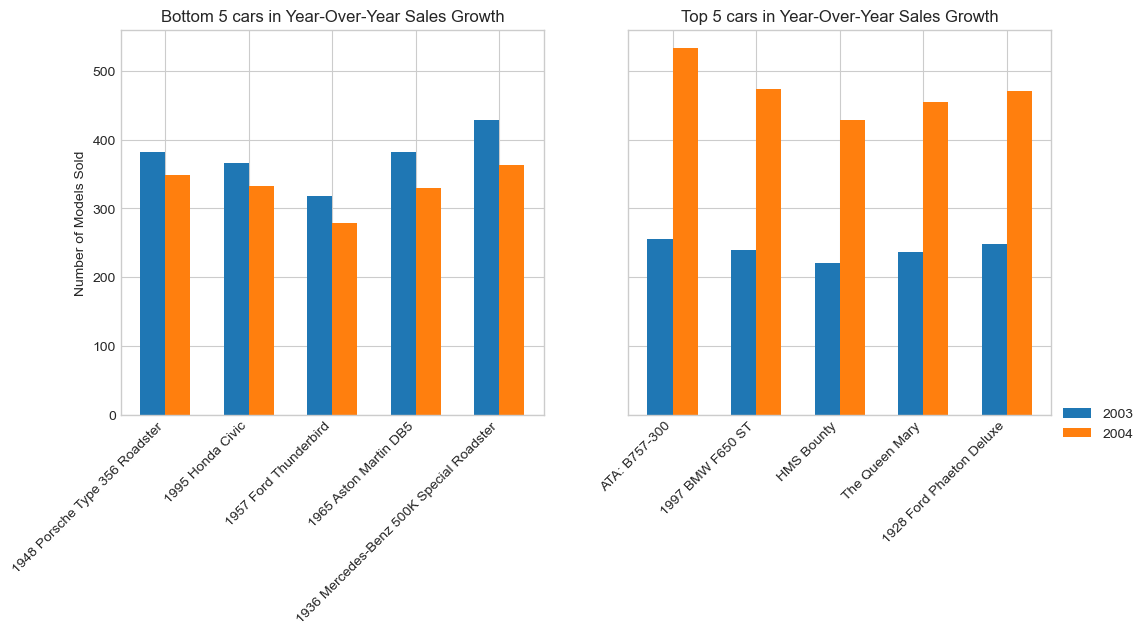

In [24]:
plt.rcParams['figure.figsize'] = [12, 5]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)



x1_pos = bot_5.index.values
x2_pos = top_5.index.values

ax1.bar(x1_pos, bot_5['qty_sold_2003'], align = 'edge', width = -.3, label = '2003')
ax1.bar(x1_pos, bot_5['qty_sold_2004'], align = 'edge', width = .3, label = '2004')
labels1 = bot_5.index
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_xticklabels(labels1, rotation=45, ha='right')
ax1.set_title("Bottom 5 cars in Year-Over-Year Sales Growth")
ax1.set(ylabel="Number of Models Sold")


ax2.bar(x2_pos, top_5['qty_sold_2003'], align = 'edge', width = -.3, label = '2003')
ax2.bar(x2_pos, top_5['qty_sold_2004'], align = 'edge', width = .3, label = '2004')
labels2 = top_5.index
ax2.set_xticks([0, 1, 2, 3, 4])
ax2.set_xticklabels(labels2, rotation=45, ha='right')
ax2.set_title("Top 5 cars in Year-Over-Year Sales Growth")

plt.legend(loc='upper left', bbox_to_anchor=(1, .05));


## Wait times by city/region


In [25]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()                   

cursor.execute("""WITH dates_by_city AS(
                  SELECT orderNumber,
                  orderDate,
                  shippedDate,
                  offices.city,
                  status
                  FROM orders
                  LEFT JOIN customers
                  ON orders.customerNumber = customers.customerNumber
                  LEFT JOIN employees
                  ON employees.employeeNumber = customers.salesRepEmployeeNumber
                  LEFT JOIN offices
                  ON employees.officeCode = offices.officeCode
                  WHERE shippedDate IS NOT NULL
                  )
                  
                  SELECT *, DATEDIFF(shippedDate, orderDate) AS tat 
                  FROM dates_by_city
                  ORDER BY tat DESC
       ;""")
output = cursor.fetchall()

cursor.close()                           
cnx.close()

tat_by_city = pd.DataFrame(output, columns = ['order_number','order_date', 'ship_date', 'city', 'status', 'tat'])

In [26]:
tat_by_city

,order_number,order_date,ship_date,city,status,tat
0,10165,2003-10-22,2003-12-26,Tokyo,Shipped,65
1,10210,2004-01-12,2004-01-20,Tokyo,Shipped,8
2,10258,2004-06-15,2004-06-23,Tokyo,Shipped,8
3,10240,2004-04-13,2004-04-20,Tokyo,Shipped,7
4,10339,2004-11-23,2004-11-30,Tokyo,Shipped,7
...,...,...,...,...,...,...
307,10382,2005-02-17,2005-02-18,San Francisco,Shipped,1
308,10385,2005-02-28,2005-03-01,San Francisco,Shipped,1
309,10398,2005-03-30,2005-03-31,Paris,Shipped,1
310,10409,2005-04-23,2005-04-24,Sydney,Shipped,1


There is one clear outlier with an extremely long turnaround time from the Tokyo branch. This is of course not typical and definitely warrants investigation. We can query the order comments from that order to see if it has any information on why the order took so long

In [27]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()                   

cursor.execute("""SELECT status,
                  comments
                  FROM orders
                  WHERE orderNumber = 10165
       ;""")
output = cursor.fetchall()

cursor.close()                           
cnx.close()

output

[('Shipped',
  "This order was on hold because customers's credit limit had been exceeded. Order will ship when payment is received")]

Since the order is likely to affect the average for the Tokyo branch and since the delay in shipping was due to the customer not exceeding their credit limit, we can remove this point from the calculation of the averaeg.

In [28]:
tat_by_city = tat_by_city.drop([0]) # since it's ordered by tat in descending order, we can just drop the first row

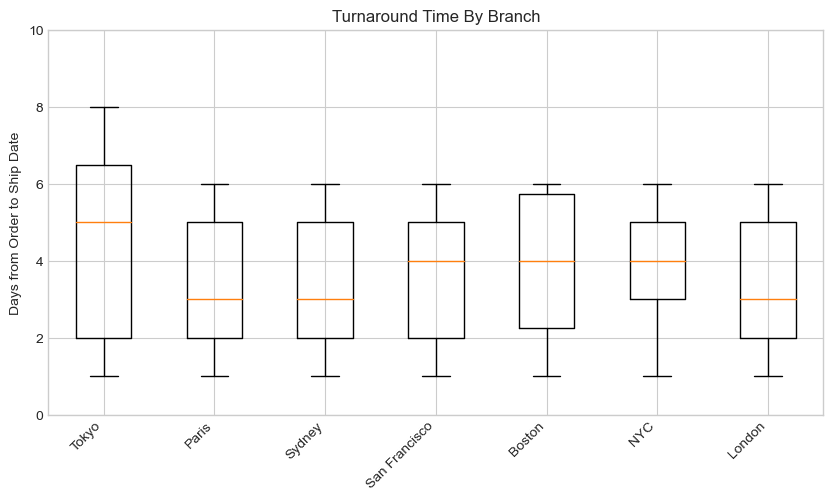

In [29]:
plt.rcParams['figure.figsize'] = [10, 5]
# Using dictionary comprehension create a dictionary that associates each price with a product line
prof_dict = {city:list(tat_by_city.loc[tat_by_city.city == city].tat.astype('float')) for city in tat_by_city.city.drop_duplicates()}

# We can plot a boxplot using the dictionary keys as the x labels, 
# which will let us get an idea of the prices associated with each product line

ax = plt.axes() 
ax.boxplot(prof_dict.values())
ax.set_xticklabels(prof_dict.keys());

# Create appropiate labels and fix the angle and position of labels
plt.ylabel('Days from Order to Ship Date'); 
plt.title('Turnaround Time By Branch')
plt.xticks(ha = 'right', rotation = 45)
plt.ylim(0,10);

## Qauntity sold by product line by month or by quarter

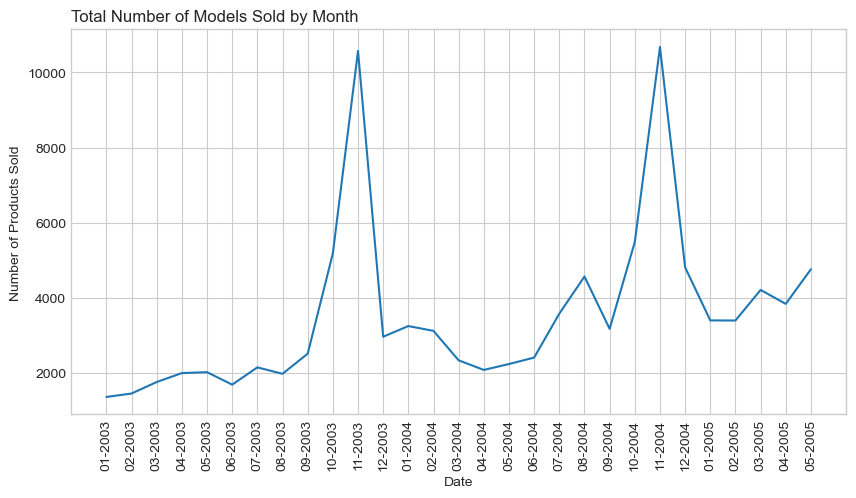

In [30]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()                   

cursor.execute(""" SELECT
                   SUM(quantityOrdered),
                   DATE_FORMAT(orderDate, '%m-%Y') AS month
                   FROM products 
                   LEFT JOIN orderdetails 
                   ON products.productCode = orderdetails.productCode
                   LEFT JOIN orders 
                   ON orderdetails.orderNumber = orders.orderNumber
                   WHERE status != 'Cancelled'
                   GROUP BY month

                    ;""")
output = cursor.fetchall()

cursor.close()                           
cnx.close()

qty_sold_time = pd.DataFrame(output, columns = ['qty_sold', 'mth_year'])

colors = ['tab:green', 'tab:blue', 'tab:orange', 'tab:red', 'tab:olive', 'tab:cyan', 'tab:pink']
    
plt.plot(qty_sold_time['mth_year'], 
        qty_sold_time['qty_sold'], 
        label = product_lines[1], c = colors[1])

plt.xticks(rotation = 90)
plt.xlabel('Date'); plt.ylabel('Number of Products Sold')
plt.title('Total Number of Models Sold by Month', loc = 'left');


As we can see plotting the overall quantity of products sold by month, there appears to be both an overall upward trend as well as an *extreme* amount of seasonality with the number of models being sold shooting through rood in the months preceding Christmas. 

In [31]:
cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()                   

cursor.execute(""" SELECT productLine,
                   SUM(quantityOrdered),
                   CONCAT(EXTRACT(YEAR FROM orderDate),'-Q', QUARTER(orderDate)) AS month
                   FROM products 
                   LEFT JOIN orderdetails 
                   ON products.productCode = orderdetails.productCode
                   LEFT JOIN orders 
                   ON orderdetails.orderNumber = orders.orderNumber
                   WHERE status != 'Cancelled'
                   GROUP BY productLine, month

                    ;""")
output = cursor.fetchall()

cursor.close()                           
cnx.close()

productline_time = pd.DataFrame(output, columns = ['product_line', 'qty_sold', 'mth_year'])
productline_time = productline_time.set_index('product_line')
productline_time

,qty_sold,mth_year
product_line,,
Vintage Cars,1436,2003-Q1
Classic Cars,1383,2003-Q1
Trucks and Buses,463,2003-Q1
Trains,119,2003-Q1
Ships,301,2003-Q1
...,...,...
Planes,891,2005-Q2
Ships,412,2005-Q2
Vintage Cars,1793,2005-Q2


In [32]:
product_lines = productline_time.index.drop_duplicates()
product_lines

Index(['Vintage Cars', 'Classic Cars', 'Trucks and Buses', 'Trains', 'Ships',
       'Planes', 'Motorcycles'],
      dtype='object', name='product_line')

''

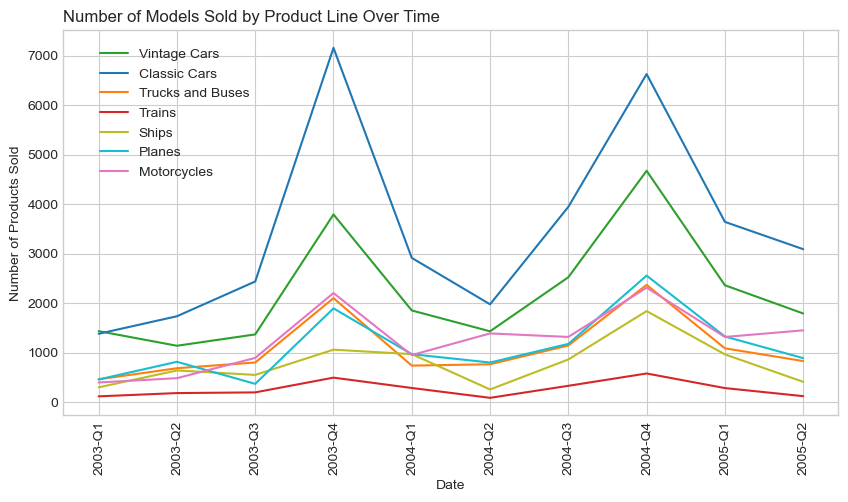

In [33]:
for i in range(len(productline_time.index.drop_duplicates())):
    plt.plot(productline_time.loc[product_lines[i], 'mth_year'], 
            productline_time.loc[product_lines[i], 'qty_sold'], 
            label = product_lines[i], c = colors[i])

plt.xticks(rotation = 90)
plt.xlabel('Date'); plt.ylabel('Number of Products Sold')
plt.title('Number of Models Sold by Product Line Over Time', loc = 'left')
plt.legend(loc=(.04,.6))


;

When we break the plot above (Quantity of products sold by month) by product line, we see that there is nothing out of the ordinary. The trend lines are fairly consistent with all product lines seeing an increase preceding Christman. As other graphs have shown, Vintage and Classic Cars make up the majority of the products sold while Trains appears to be 